In [151]:
import utils.eigenstate_generator as eig
import utils.cs_vqe as c
import utils.cs_vqe_ansatz as c_anz
import utils.qubit_conversion as qonvert
import ast
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from copy import deepcopy
from openfermion.linalg import LinearQubitOperator, get_sparse_operator, get_ground_state
import itertools
from statistics import median

In [8]:
import openfermion
import openfermionpyscf
from openfermion import MolecularData
from openfermionpyscf import run_pyscf
from openfermion.ops import FermionOperator, QubitOperator
from openfermion.transforms import jordan_wigner, bravyi_kitaev
from openfermion.transforms import get_fermion_operator
from openfermion.circuits import (uccsd_singlet_get_packed_amplitudes,
                               uccsd_singlet_generator, uccsd_generator,
                               uccsd_convert_amplitude_format)

singlet_bool = True # Set general UCCSD or singlet UCCSD.

bond_len = 0.772#1.45
atom_1 = 'He'
atom_2 = 'H'
basis = '3-21g'
multiplicity = 1
charge = 1

coordinate_1 = (0.0, 0.0, 0.0)
coordinate_2 = (0.0, 0.0, bond_len)
geometry = [(atom_1, coordinate_1), (atom_2, coordinate_2)]

molecule_data = MolecularData(geometry, basis, multiplicity, charge, description='Test')
#molecule.load()

# Set calculation parameters.
run_scf = 1
run_mp2 = 1
run_cisd = 0
run_ccsd = 0
run_fci = 1
delete_input = True
delete_output = True

# Run pyscf.
molecule = run_pyscf(molecule_data,
                     run_scf=run_scf,
                     run_mp2=run_mp2,
                     run_cisd=run_cisd,
                     run_ccsd=run_ccsd,
                     run_fci=run_fci)

#molecule.load()
#print(molecule)

ham = get_fermion_operator(molecule.get_molecular_hamiltonian())
ham_q = jordan_wigner(ham)
print('Hamiltonian:', '\n', ham_q, '\n')

scf = True      # Hartree-Fock.
mp2 = True      # Moller-Plesset 2.
cisd = True     # Configuration interaction singles and doubles.
ccsd = True     # Coupled cluster singles and doubles.
fci = True      # Full configuration interaction.

calculated_molecule = run_pyscf(molecule_data, scf, mp2, cisd, ccsd, fci)

if ccsd:
    ccsd_single_amps = calculated_molecule.ccsd_single_amps
    ccsd_double_amps = calculated_molecule.ccsd_double_amps

num_electrons = calculated_molecule.n_electrons
num_qubits = 2*calculated_molecule.n_orbitals

if singlet_bool:
    # Get singlet UCCSD generator.
    packed_amps = uccsd_singlet_get_packed_amplitudes(ccsd_single_amps,  ccsd_double_amps, num_qubits, num_electrons)
    ucc_sing = uccsd_singlet_generator(packed_amps, num_qubits, num_electrons)
    #print(ucc_sing)

else:
    # Get general UCCSD operator.
    ucc_op = uccsd_generator(ccsd_single_amps, ccsd_double_amps)
    #print(ucc_op)
    
ucc_q = jordan_wigner(ucc_sing)
ucc = qonvert.QubitOperator_to_dict(ucc_q, num_qubits)
print('UCCSD ansatz:', '\n', ucc_q)

Hamiltonian: 
 (1.1324434021069398+0j) [] +
(-0.02581025441481511+0j) [X0 X1 Y2 Y3] +
(-0.012799934786436963+0j) [X0 X1 Y2 Z3 Z4 Y5] +
(-0.025159645839897986+0j) [X0 X1 Y2 Z3 Z4 Z5 Z6 Y7] +
(-0.012799934786436963+0j) [X0 X1 X3 X4] +
(-0.025159645839897986+0j) [X0 X1 X3 Z4 Z5 X6] +
(-0.017114528821774628+0j) [X0 X1 Y4 Y5] +
(-0.0009891049103626785+0j) [X0 X1 Y4 Z5 Z6 Y7] +
(-0.0009891049103626785+0j) [X0 X1 X5 X6] +
(-0.054698565746849344+0j) [X0 X1 Y6 Y7] +
(0.02581025441481511+0j) [X0 Y1 Y2 X3] +
(0.012799934786436963+0j) [X0 Y1 Y2 Z3 Z4 X5] +
(0.025159645839897986+0j) [X0 Y1 Y2 Z3 Z4 Z5 Z6 X7] +
(-0.012799934786436963+0j) [X0 Y1 Y3 X4] +
(-0.025159645839897986+0j) [X0 Y1 Y3 Z4 Z5 X6] +
(0.017114528821774628+0j) [X0 Y1 Y4 X5] +
(0.0009891049103626785+0j) [X0 Y1 Y4 Z5 Z6 X7] +
(-0.0009891049103626785+0j) [X0 Y1 Y5 X6] +
(0.054698565746849344+0j) [X0 Y1 Y6 X7] +
(0.002577905179412341+0j) [X0 Z1 X2] +
(0.004766148105680654+0j) [X0 Z1 X2 X3 Z4 X5] +
(-0.009264702923307964+0j) [X0 Z1 X2 X3

UCCSD ansatz: 
 0.006478936130102838j [X0 X1 X2 Y3] +
0.006478936130102838j [X0 X1 Y2 X3] +
0.0020562744029710704j [X0 X1 X4 Y5] +
0.0020562744029710704j [X0 X1 Y4 X5] +
0.005083283191416048j [X0 X1 X6 Y7] +
0.005083283191416048j [X0 X1 Y6 X7] +
-0.006478936130102838j [X0 Y1 X2 X3] +
0.006478936130102838j [X0 Y1 Y2 Y3] +
-0.0020562744029710704j [X0 Y1 X4 X5] +
0.0020562744029710704j [X0 Y1 Y4 Y5] +
-0.005083283191416048j [X0 Y1 X6 X7] +
0.005083283191416048j [X0 Y1 Y6 Y7] +
-0.006360390047729467j [X0 Z1 Y2] +
-0.002645411873769119j [X0 Z1 Z2 Z3 Y4] +
0.0009221551709274561j [X0 Z1 Z2 Z3 Z4 Z5 Y6] +
-0.006478936130102838j [Y0 X1 X2 X3] +
0.006478936130102838j [Y0 X1 Y2 Y3] +
-0.0020562744029710704j [Y0 X1 X4 X5] +
0.0020562744029710704j [Y0 X1 Y4 Y5] +
-0.005083283191416048j [Y0 X1 X6 X7] +
0.005083283191416048j [Y0 X1 Y6 Y7] +
-0.006478936130102838j [Y0 Y1 X2 Y3] +
-0.006478936130102838j [Y0 Y1 Y2 X3] +
-0.0020562744029710704j [Y0 Y1 X4 Y5] +
-0.0020562744029710704j [Y0 Y1 Y4 X5] +
-0.0

In [9]:
#import itertools
#bin_strings = [''.join(s) for s in list(itertools.product(['0','1'], repeat=num_qubits))]

In [10]:
#for b in bin_strings:
#    hf=np.array([0 for i in range(2**num_qubits)])
#    hf[eig.bin_to_int(b)] = 1
#    psi = LinearQubitOperator(ucc_q).matvec(hf)
#    psi_conj = np.conjugate(psi)
#    psi = psi/np.sqrt((psi_conj.dot(psi)))
#    psi_conj = np.conjugate(psi)
#    expect = eig.expectation(ham_q, psi, num_qubits)
#    if expect < -3:
#        print(b, psi_conj.dot(psi), expect)
#print('finished')

In [11]:
ham = qonvert.QubitOperator_to_dict(ham_q, num_qubits)
#anz_terms = list((qonvert.QubitOperator_to_dict(ucc_q, num_qubits)).keys())

#noncontextual hamiltonian
terms_noncon = c.greedy_dfs(ham, 1, criterion='weight')[-1]
ham_noncon = {t:ham[t] for t in terms_noncon}
#contextual hamiltonian
ham_context = {p:c for p,c in ham.items() if p not in ham_noncon}

#construct the epistricted model
model = c.quasi_model(ham_noncon)
fn_form = c.energy_function_form(ham_noncon, model)
gs_noncon = c.find_gs_noncon(ham_noncon)
gs_noncon_energy = gs_noncon[0]
ep_state = gs_noncon[1]
generators = {g:gs_noncon[1][0][index] for index, g in enumerate(model[0])}
A = {p:ep_state[1][index] for index, p in enumerate(model[1])}
r1 = ep_state[1][0]
r2 = ep_state[1][1]

#rotate the hamiltonians
rotations = (c.diagonalize_epistemic(model,fn_form,ep_state))[0]
ham, ham_noncon, ham_context = eig.rotate_hamiltonian(rotations, ham, ham_noncon, ham_context)
generators = eig.rotate_operator(rotations, generators)
A = eig.rotate_operator(rotations, A)
ucc = eig.rotate_operator(rotations, ucc)

In [12]:
print('commuting generators:',generators, '\n')
print('anticommuting generators:',A, '\n')
#print('Minimising configuration:', gs_noncon[1])

commuting generators: {'ZIIIIIII': 1.0, 'IZIIIIII': 1.0, 'IIZIIIII': -1.0, 'IIIZIIII': 1.0, 'IIIIZIII': 1.0, 'IIIIIZII': 1.0, 'IIIIIIZI': 1.0} 

anticommuting generators: {'IIZZZZIX': -0.04017214145491281, 'IIIIIIIZ': 0.9991927737183284} 



In [13]:
ham_q = qonvert.dict_to_QubitOperator(ham, num_qubits)
ham_noncon_q = qonvert.dict_to_QubitOperator(ham_noncon, num_qubits)
ham_context_q = qonvert.dict_to_QubitOperator(ham_context, num_qubits)
initial_state='00010000'

#take expectation value algebraically
psi = eig.add_eigenstate(molecule='HeH+', r1=r1, r2=r2, index=16, theta=0, num_qubits=num_qubits, rot=True)
#psi = eig.rotate_state(rotations, psi, num_qubits)
expect = eig.expectation(ham_q, psi, num_qubits)

print('<H> w.r.t. simultaneous eigenstate:', expect)
print('Noncontextual approximation:', gs_noncon_energy)
print('Expectation values match?', abs(expect - gs_noncon_energy) < 10**-12) #sanity check - expectation values match?

<H> w.r.t. simultaneous eigenstate: (-3.142824749268176+0j)
Noncontextual approximation: -3.142824749268178
Expectation values match? True


In [14]:
qmap = eig.qubit_map('HeH+', num_qubits, rot=True)

In [15]:
qmap_expect=[]
for i in eig.find_eigenstate_indices('00010000', [3, 2, 7]):
    psi = eig.add_eigenstate(molecule='HeH+', r1=r1, r2=r2, index=i, theta=0, num_qubits=num_qubits, rot=True)
    expect = eig.expectation(ham_q, psi, num_qubits)
    qmap_expect.append([expect, qmap[i]])

In [16]:
sorted(qmap_expect, key=lambda x:x[0])

[[(-3.142824749268176+0j), [(16, '00010000'), (18, '00010010')]],
 [(-3.1413189812837823+0j), [(32, '00100000'), (34, '00100010')]],
 [(-2.886300591726715+0j), [(0, '00000000'), (2, '00000010')]],
 [(-2.8515477661947966+0j), [(48, '00110000'), (50, '00110010')]],
 [(-0.570492219865814+0j), [(33, '00100001'), (35, '00100011')]],
 [(-0.5268113957535533+0j), [(17, '00010001'), (19, '00010011')]],
 [(-0.29147279190058706+0j), [(49, '00110001'), (51, '00110011')]],
 [(-0.25953545108833515+0j), [(1, '00000001'), (3, '00000011')]]]

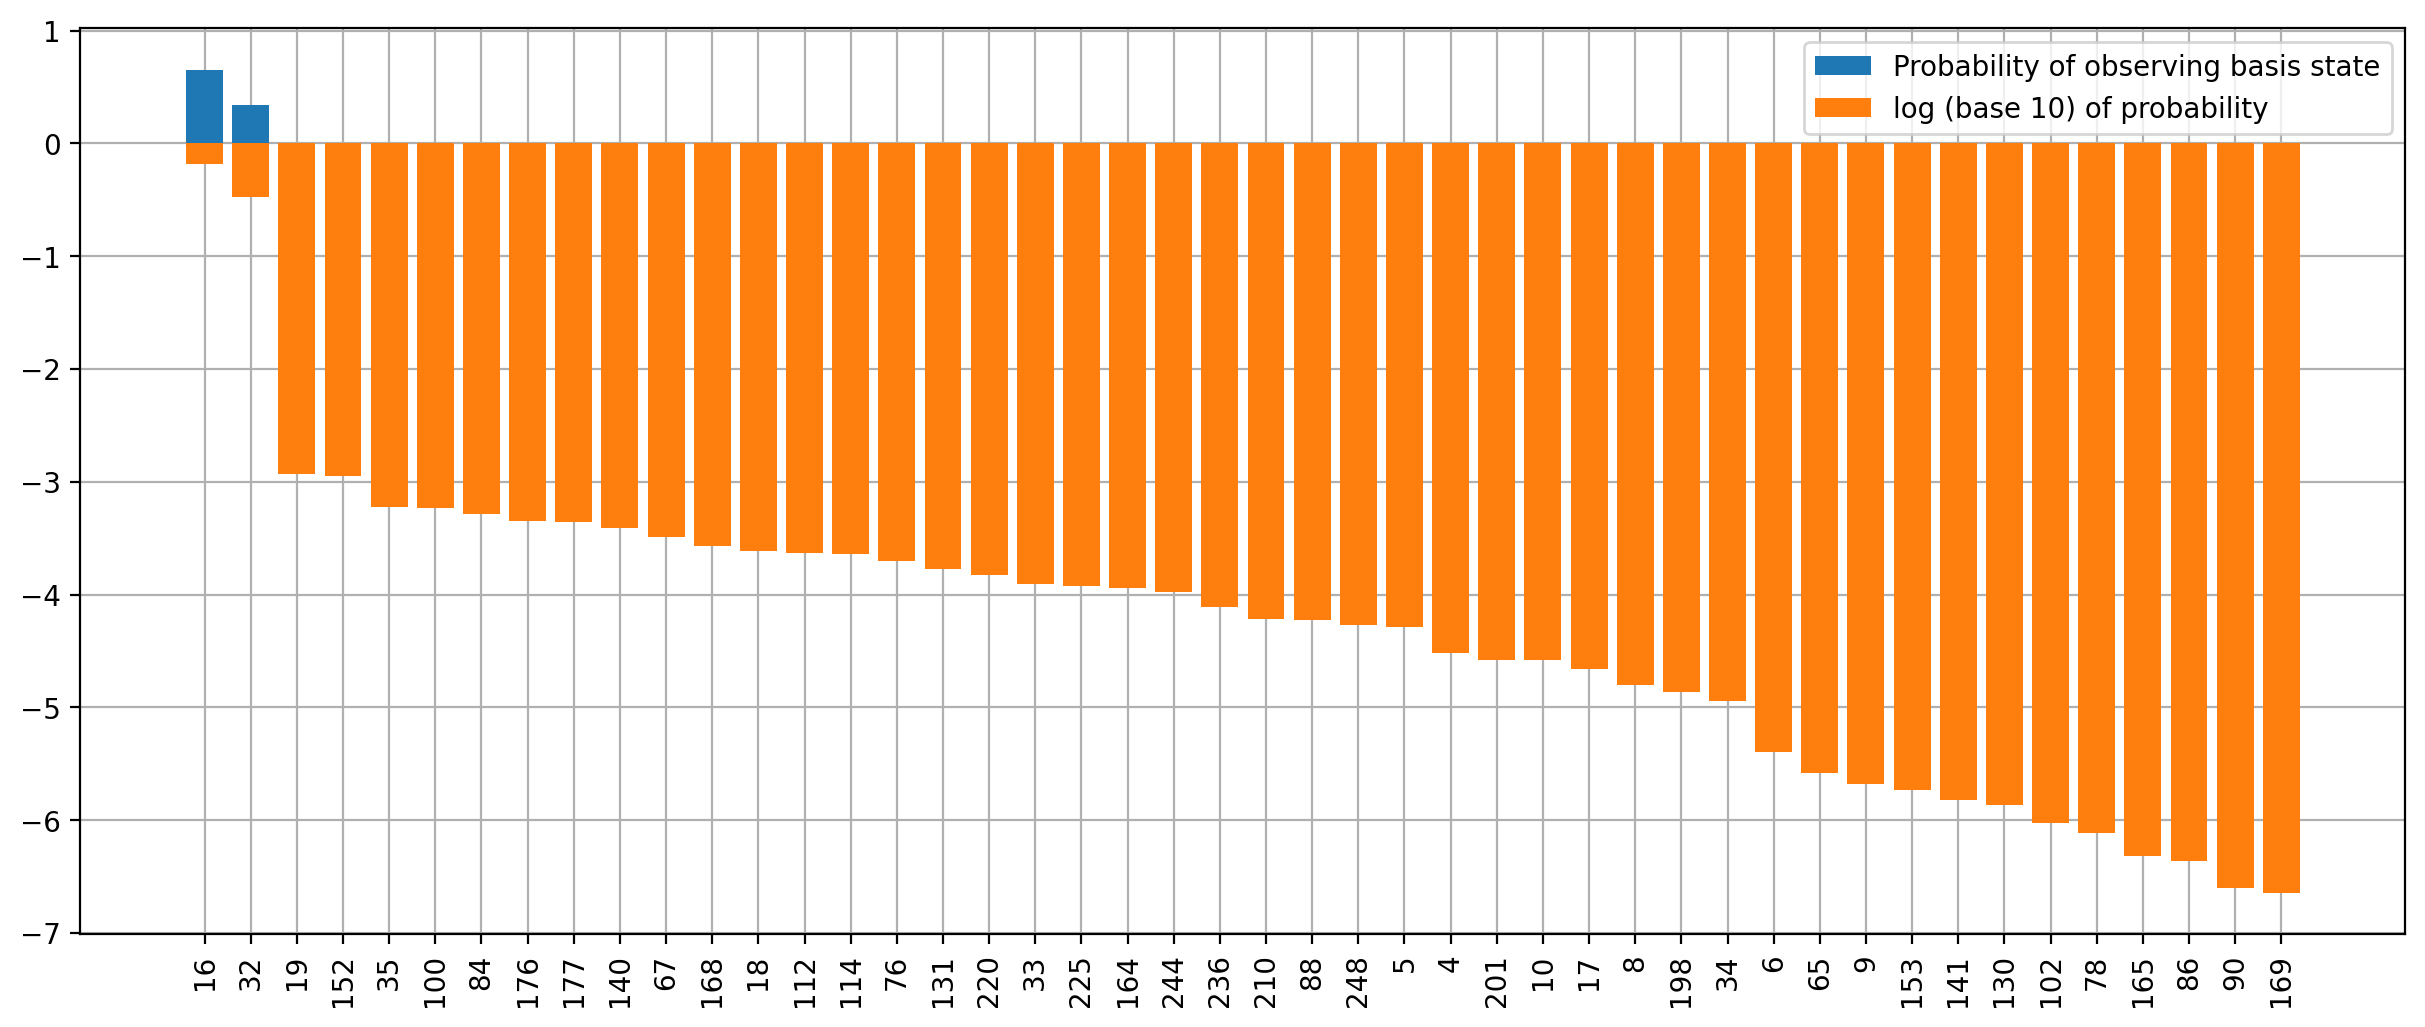

In [17]:
gs = get_ground_state(get_sparse_operator(ham_q, num_qubits).toarray())
true_gs = gs[0]

amp_list = [abs(a)**2 for a in list(gs[1])]
sig_amp_list = sorted([(str(index), a) for index, a in enumerate(amp_list) if a > 10**-7], key=lambda x:x[1])
sig_amp_list.reverse()

XY = list(zip(*sig_amp_list))
X = XY[0]
Y = XY[1]
Y_log = [np.log10(a) for a in Y]

from matplotlib.pyplot import figure

figure(figsize=(15, 6), dpi=200)

plt.grid(zorder=0)
plt.bar(X, Y, zorder=2, label='Probability of observing basis state')
plt.bar(X, Y_log, zorder=3, label = 'log (base 10) of probability')
plt.xticks(rotation=90)
plt.legend()
plt.show()

In [18]:
true_gs

-3.166765477254404

[] []


/home/tim/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/tim/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:171: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order, subok=True)


['ZIIIIIII'] [0]
['IZIIIIII', 'ZIIIIIII'] [1, 0]


KeyboardInterrupt: 

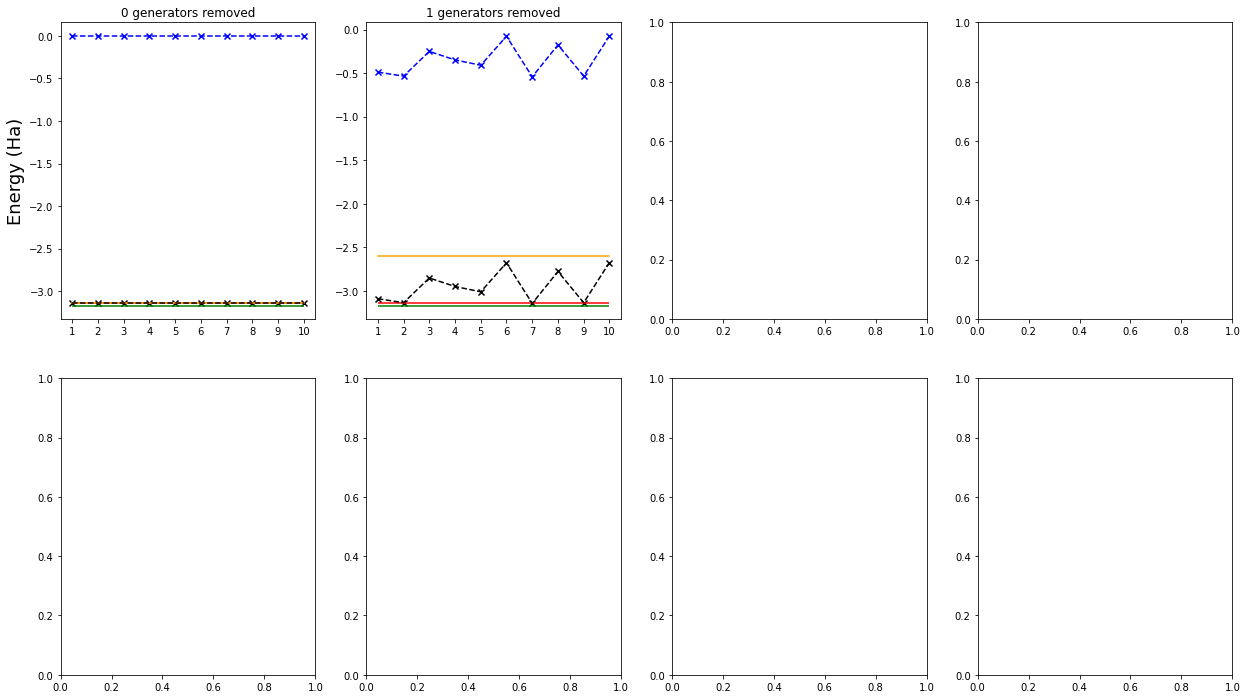

In [152]:
#take expectation value algebraically
from matplotlib import pyplot as plt
shots=10
#rot_ham, rot_ham_noncon, rot_ham_context = rotate_hamiltonian(rotations, ham, ham_noncon, ham_context)
molecule='HeH+'

fig, axs = plt.subplots(nrows = 2, ncols = 4, figsize = (21,12))
grid_pos = [(0,0),(0,1),(0,2),(0,3),(1,0),(1,1),(1,2),(1,3)]
#grid_pos.reverse()

X=list(range(1, shots+1))

for index, grid in enumerate(grid_pos):
    
    removed_index = list(range(0, index))
    removed_index.reverse()
    removed_generators = [list(generators.keys())[i] for i in removed_index]
    Z_indices = [g.find('Z') for g in removed_generators]
    print(removed_generators, Z_indices)
    
    new_ham_noncon, new_ham_context = eig.discard_generator(ham_noncon, ham_context, removed_generators)
    new_ham_noncon_q = qonvert.dict_to_QubitOperator(new_ham_noncon, num_qubits)
    new_ham_context_q = qonvert.dict_to_QubitOperator(new_ham_context, num_qubits)

    random_amplitudes=[]
    for i in range(shots):  
        rand_vec = eig.random_vector(2**len(removed_index))
        rand_vec = sorted([eig.random_complex_unit()*c for c in rand_vec], key=abs)
        rand_vec.reverse()
        random_amplitudes.append(rand_vec)
        
    Y_noncon=[]
    Y_context=[]
    Y_combined=[]
    Y_full=[]

    #A_op = QubitOperator('Y0 Z1 Z2 Z3 Z4 Z5 Y6 Z7', r1) + QubitOperator('Z6', r2)
    #A = LinearQubitOperator(A_op, num_qubits)

    for amps in random_amplitudes:
        expect_noncon, expect_context = eig.expectation_optimiser(molecule=molecule, ham_n=new_ham_noncon_q, ham_c=new_ham_context_q, 
                                                                  r1=r1, r2=r2, amps=amps, initial_state=initial_state,num_qubits=num_qubits,
                                                                  Z_indices=Z_indices,rot=True)

        #Y_full.append(expect_full)
        Y_noncon.append(expect_noncon)
        Y_context.append(expect_context)
        Y_combined.append(expect_noncon+expect_context)

        #print(p, expect_noncon + expect_context < gs_noncon_energy)
        #print((np.conjugate(psi)).dot(psi))
        #Verify +1-eigenstate
        #A_psi = A.matvec(psi)
        #print(psi_conj.dot(A_psi))
    
    axs[grid].plot(X, Y_noncon, color='orange')
    axs[grid].scatter(X, Y_context, color='blue', marker = 'x')
    axs[grid].plot(X, Y_context, color='blue', ls='--')
    axs[grid].scatter(X, Y_combined, color='black', marker = 'x')
    axs[grid].plot(X, Y_combined, color='black', ls='--')
    #plt.plot(range(shots), Y_combined, color='purple')
    axs[grid].hlines(gs_noncon_energy, 1, shots, color='r')
    axs[grid].hlines(true_gs, 1, shots, color='g')
    
    axs[grid].set_xticks(X)
    axs[grid].set_title("%i generators removed" % abs(index))
    if grid[0] == 1:
        axs[grid].set_xlabel('Sample Number',fontsize=16)
    if grid[1] == 0:
        axs[grid].set_ylabel('Energy (Ha)',fontsize=18)
    #print('<H> w.r.t. simultaneous eigenstate:', expect)
    #print('Noncontextual approximation:', gs_noncon_energy)
    #print('Expectation values match?', abs(expect - gs_noncon_energy) < 10**-12) #sanity check - expectation values match? 

In [60]:
from qiskit.circuit.parameter import Parameter
from qiskit.circuit.quantumcircuit import QuantumCircuit
from qiskit import QuantumCircuit, BasicAer, execute
from qiskit.visualization import plot_histogram
from qiskit.utils import QuantumInstance
from qiskit.aqua.components.optimizers import SLSQP
from qiskit.algorithms import VQE
from qiskit import Aer

amp_ratio = (1 + r2) / (r1)
t1 = np.arctan(-amp_ratio)
t2 = np.arctan(+amp_ratio)

anz=QuantumCircuit(num_qubits+1)

anz = c_anz.construct_ansatz(init_state=[4], paulis=list(ucc.keys()))
#anz.x(4)
#anz += c_anz.exp_P('IIIZYIZZI', rot=np.pi/2)

##store parity in auxiliary qubit (8) via CNOT cascade
#anz.cx(2, 3),anz.cx(3, 4),anz.cx(4, 5),anz.cx(5, 6),anz.cx(6, 8)
##move into +1-eigenstate
#anz.cry(2*t2+0.2, 8, 1)
#anz.x(8)
#anz.cry(2*t2+0.2, 8, 1)
#anz.x(8)
##reverse CNOT cascade
#anz.cx(6, 8),anz.cx(5, 6), anz.cx(4, 5), anz.cx(3, 4), anz.cx(2, 3)
#anz.x(1)

anz.measure_all()
print(anz.draw())
backend = BasicAer.get_backend('qasm_simulator')
job = execute(anz, backend)
plot_histogram(job.result().get_counts(), color='midnightblue', title="New Histogram")

              ░ ┌─────┐┌───┐                                           ┌───┐»
   q_0: ──────░─┤ SDG ├┤ H ├──■─────────────────────────────────────■──┤ H ├»
              ░ └─────┘└───┘┌─┴─┐                                 ┌─┴─┐└───┘»
   q_1: ──────░─────────────┤ X ├──■───────────────────────────■──┤ X ├─────»
              ░  ┌───┐      └───┘┌─┴─┐                       ┌─┴─┐├───┤     »
   q_2: ──────░──┤ H ├───────────┤ X ├──■─────────────────■──┤ X ├┤ H ├─────»
              ░  └───┘           └───┘  │                 │  └───┘└───┘     »
   q_3: ──────░─────────────────────────┼─────────────────┼─────────────────»
        ┌───┐ ░                         │                 │                 »
   q_4: ┤ X ├─░─────────────────────────┼─────────────────┼─────────────────»
        └───┘ ░                         │                 │                 »
   q_5: ──────░─────────────────────────┼─────────────────┼─────────────────»
              ░                         │                 │     

QiskitError: 'Mismatch between run_config.parameter_binds and all circuit parameters. Parameter binds: [] Circuit parameters: [ParameterView([Parameter(αβγ), Parameter(αβδ), Parameter(αβε), Parameter(αβζ), Parameter(αβη), Parameter(αβθ), Parameter(αβι), Parameter(αβκ), Parameter(αβλ), Parameter(αβμ), Parameter(αβν), Parameter(αβξ), Parameter(αβο), Parameter(αβπ), Parameter(αβρ), Parameter(αβς), Parameter(αβσ), Parameter(αβτ), Parameter(αβυ), Parameter(αβφ), Parameter(αβχ), Parameter(αβψ), Parameter(αβω), Parameter(αγδ), Parameter(αγε), Parameter(αγζ), Parameter(αγη), Parameter(αγθ), Parameter(αγι), Parameter(αγκ), Parameter(αγλ), Parameter(αγμ), Parameter(αγν), Parameter(αγξ), Parameter(αγο), Parameter(αγπ)])]'

In [127]:
removed_generators = ['ZIIIIIII', 'IZIIIIII', 'IIZIIIII','IIIZIIII','IIIIZIII','IIIIIZII', 'IIIIIIIZ']
new_ham_noncon, new_ham_context = eig.discard_generator(ham_noncon, ham_context, removed_generators)
vqe_input_ham_noncon = qonvert.dict_to_WeightedPauliOperator(new_ham_noncon)
vqe_input_ham_context = qonvert.dict_to_WeightedPauliOperator(new_ham_context)

qi = QuantumInstance(Aer.get_backend('statevector_simulator'))

slsqp = SLSQP(maxiter=10000)

counts = []
values = []
def store_intermediate_result(eval_count, parameters, mean, std):
    counts.append(eval_count)
    values.append(mean)

amp_ratio = (1 + r2) / (r1)
t1 = np.arctan(-amp_ratio)
t2 = np.arctan(+amp_ratio)

anz=QuantumCircuit(num_qubits)

anz.x(4)
anz.rx(Parameter('a'), 7)
anz.rx(Parameter('b'), 6)
anz.rx(Parameter('c'), 5)
anz.rx(Parameter('d'), 4)
anz.rx(Parameter('e'), 3)
anz.rx(Parameter('f'), 2)
anz.rx(Parameter('g'), 0)
#anz.rx(Parameter('b'), 5)

#store parity in auxiliary qubit (8) via CNOT cascade
anz.cx(2, 3),anz.cx(3, 4),anz.cx(4, 5),anz.cx(5, 6),anz.cx(6, 0)
#move into +1-eigenstate
anz.cry(2*t1, 0, 1)
anz.x(0)
anz.cry(2*t2, 0, 1)
anz.x(0)
#reverse CNOT cascade
anz.cx(6, 0),anz.cx(5, 6), anz.cx(4, 5), anz.cx(3, 4), anz.cx(2, 3)
anz.x(1)


#ucc_reversed=[]
#for p in list(ucc.keys()):
#    p_ref = list(deepcopy(p))
#    p_ref.reverse()
#    ucc_reversed.append(''.join(p_ref))####

#anz = c_anz.construct_ansatz(init_state=[4], paulis=ucc_reversed, trot_order=2)
##anz += anz#= c_anz.construct_ansatz(paulis=ucc_reversed, circ=anz, index_offset=100) #trotterise
##print(anz.draw())
#vqe = VQE(anz, optimizer=slsqp, callback=store_intermediate_result, quantum_instance=qi)#

#vqe_input_ham = qonvert.dict_to_WeightedPauliOperator(ham)
#vqe_run = vqe.compute_minimum_eigenvalue(operator=vqe_input_ham)
#vqe_result = vqe_run.optimal_value

#print('VQE:', vqe_result)

vqe = VQE(anz, optimizer=slsqp, callback=store_intermediate_result, quantum_instance=qi)

# run VQE on noncontextual hamiltonian to verify we are in +1-eigenspace
vqe_run_noncon = vqe.compute_minimum_eigenvalue(operator=vqe_input_ham_noncon)
X_noncon = deepcopy(counts)
Y_noncon = deepcopy(values)
counts.clear(), values.clear()

# run VQE on contextual hamiltonian
vqe_run_context = vqe.compute_minimum_eigenvalue(operator=vqe_input_ham_context)
X_context = deepcopy(counts)
Y_context = deepcopy(values)

vqe_result_noncon = vqe_run_noncon.optimal_value
vqe_result_context = vqe_run_context.optimal_value
vqe_result = vqe_result_noncon + vqe_result_context

print('VQE:', vqe_result_noncon,'+', vqe_result_context,'=', vqe_result, '|', 'Improves noncontextual estimate?', vqe_result<gs_noncon_energy)

VQE: -0.006852717631969627 + -3.1344662131591363 = -3.141318930791106 | Improves noncontextual estimate? False


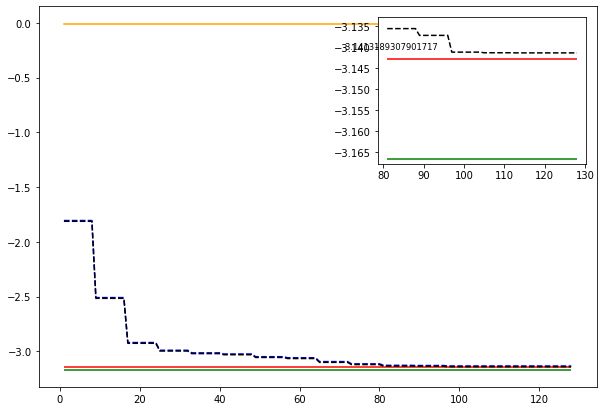

In [128]:
fig, ax = plt.subplots(figsize = (10, 7))

X=X_context
conv_diff = len(X_context) - len(X_noncon)

if conv_diff < 0:
    Y_noncon = Y_noncon[0:len(X)]
else:
    for i in range(conv_diff):
        Y_noncon.append(Y_noncon[-1])

Y_total = [sum(x) for x in zip(Y_noncon, Y_context)]

ax.plot(X, Y_noncon, color='orange')
#plt.scatter(X, Y_context, color='blue', marker = 'x')
ax.plot(X, Y_context, color='blue', ls='--')
#plt.scatter(X, Y_total, color='black', marker = 'x')
ax.plot(X, Y_total, color='black', ls='--')

X_zoom = []
Y_zoom = []
for index, t in enumerate(Y_total):
    if t-0.01 < gs_noncon_energy:
        X_zoom.append(X[index])
        Y_zoom.append(t)

# location for the zoomed portion 
sub_axes = plt.axes([.596, .568, .29, .29]) 

# plot the zoomed portion
sub_axes.set_ylim((true_gs-0.001, gs_noncon_energy+0.01))
sub_axes.plot(X_zoom, Y_zoom, color='black', ls='--')
sub_axes.hlines(gs_noncon_energy, X_zoom[0], X_zoom[-1], color='r')
sub_axes.hlines(true_gs, X_zoom[0], X_zoom[-1], color='g')
sub_axes.text(70, Y_total[-1]+0.001, str(Y_total[-1]), size='small')

ax.hlines(gs_noncon_energy, 1, len(X), color='r')
ax.hlines(true_gs, 1, len(X), color='g')

Removed generators: [] []
VQE result: -3.142824749268175 Improvement? False | Noncontextual: -3.142824749268178 True: -3.166765477254404
Removed generators: ['ZIIIIIII'] [7]
VQE result: -3.142824598478299 Improvement? False | Noncontextual: -3.142824749268178 True: -3.166765477254404
Removed generators: ['IZIIIIII', 'ZIIIIIII'] [6, 7]
VQE result: -3.142824727248242 Improvement? False | Noncontextual: -3.142824749268178 True: -3.166765477254404
Removed generators: ['IIZIIIII', 'IZIIIIII', 'ZIIIIIII'] [5, 6, 7]
VQE result: -3.1438293745762924 Improvement? True | Noncontextual: -3.142824749268178 True: -3.166765477254404
Removed generators: ['IIIZIIII', 'IIZIIIII', 'IZIIIIII', 'ZIIIIIII'] [4, 5, 6, 7]
VQE result: -3.143842247047728 Improvement? True | Noncontextual: -3.142824749268178 True: -3.166765477254404
Removed generators: ['IIIIZIII', 'IIIZIIII', 'IIZIIIII', 'IZIIIIII', 'ZIIIIIII'] [3, 4, 5, 6, 7]
VQE result: -3.1472764491722947 Improvement? True | Noncontextual: -3.142824749268178

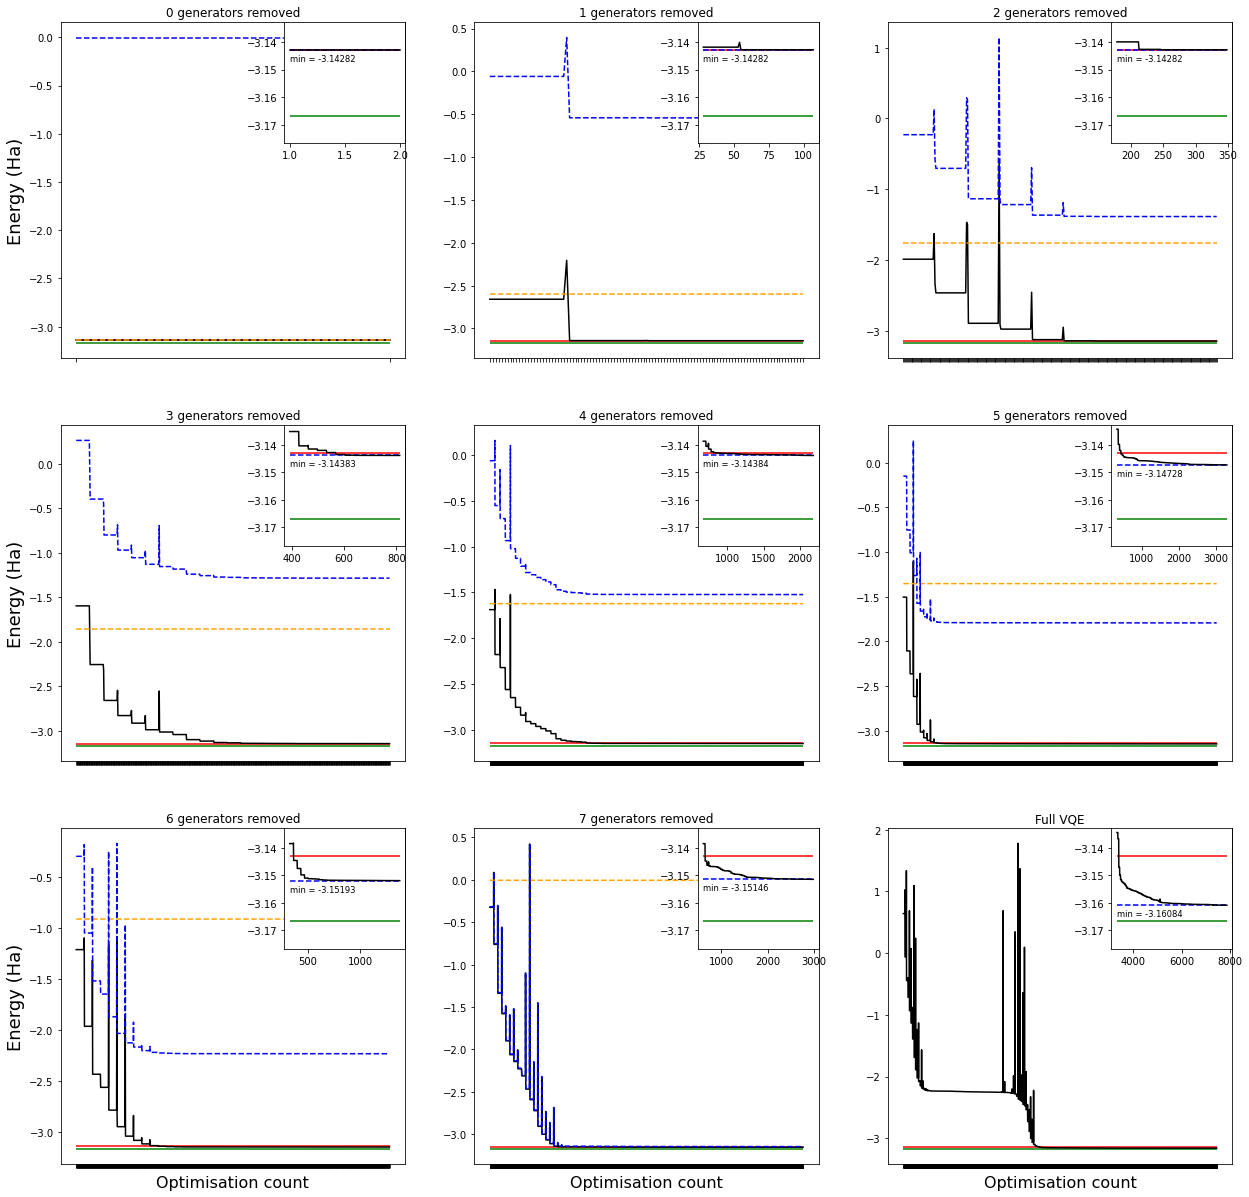

In [157]:
#VQE setup
qi = QuantumInstance(Aer.get_backend('statevector_simulator'))
slsqp = SLSQP(maxiter=10000)
counts = []
values = []

def store_intermediate_result(eval_count, parameters, mean, std):
    counts.append(eval_count)
    values.append(mean)

# create blank plot
fig, axs = plt.subplots(nrows = 3, ncols = 3, figsize = (21,21))
grid_pos = [(0,0),(0,1),(0,2),(1,0),(1,1),(1,2),(2,0),(2,1),(2,2)]

# compute +1-eigenspace quotient
amp_ratio = (1 + r2) / (r1)
t1 = np.arctan(-amp_ratio)
t2 = np.arctan(+amp_ratio)

# create blank parameters to assign in circuit for VQE optimsisation
param_chars = ['α','β','γ','δ','ε','ζ','η','θ','ι','κ','λ','μ','ν','ξ','ο','π','ρ','ς','σ','τ','υ','φ','χ','ψ','ω']
params = [] 
for comb in list(itertools.combinations(param_chars, 2)):
    char_str = ''.join(comb)
    params.append(Parameter(char_str))

#discard generators left to right whilst performing VQE
for index, grid in enumerate(grid_pos):
    
    if grid == (2,2):
        print('Running full VQE routine...')
        ucc_fix = []
        for p in ucc.keys():
            p_list = list(deepcopy(p))
            p_list.reverse()
            ucc_fix.append(''.join(p_list))
            #print(p_list)
        #print(ucc_fix)
        anz = c_anz.construct_ansatz(init_state = [4], paulis=ucc_fix, trot_order=2)
        
        vqe_input_ham_noncon = qonvert.dict_to_WeightedPauliOperator(new_ham_noncon)
        vqe_input_ham_context = qonvert.dict_to_WeightedPauliOperator(ham)
    
    else:
        removed_index = list(range(0, index))
        removed_index.reverse()
        removed_generators = [list(generators.keys())[i] for i in removed_index]
        Z_indices = [7 - g.find('Z') for g in removed_generators]

        print('Removed generators:', removed_generators, Z_indices)

        new_ham_noncon, new_ham_context = eig.discard_generator(ham_noncon, ham_context, removed_generators)
        new_ham_noncon_add_q8={}
        new_ham_context_add_q8={}
        for p in new_ham_noncon.keys():
            p_add_q = 'I' + p
            new_ham_noncon_add_q8[p_add_q] = new_ham_noncon[p]
        for p in new_ham_context.keys():
            p_add_q = 'I' + p
            new_ham_context_add_q8[p_add_q] = new_ham_context[p]

        vqe_input_ham_noncon = qonvert.dict_to_WeightedPauliOperator(new_ham_noncon_add_q8)
        vqe_input_ham_context = qonvert.dict_to_WeightedPauliOperator(new_ham_context_add_q8)

        # initiate blank circuit
        anz=QuantumCircuit(num_qubits + 1)

        # noncontextual reference
        anz.x(4)

        # search over space not fixed by generators
        if Z_indices == []:
            anz.rz(params[0], 4) # because VQE needs at least one parameter...
        else:
            #param_index = 0
            #over_P = ['I' for i in range(num_qubits+1)]
            #for z in Z_indices:
            #    blank_P = ['I' for i in range(num_qubits+1)]
            #    blank_P[z] = 'X'
            #    over_P[z] = 'X'
            #    anz += c_anz.exp_P(''.join(blank_P), rot = params[param_index])
            #    anz += c_anz.exp_P(''.join(over_P), rot = params[param_index+1])
            #    param_index += 2

            ucc_fix = []
            Z_complement = list(set(range(num_qubits)) - set(Z_indices))
            #print(Z_complement)
            for p in ucc.keys():
                p_list = list(deepcopy(p))
                p_list.reverse()
                #p_list[6] = 'I'
                #p_list[7] = 'I'
                for z in Z_complement:     
                    p_list[z] = 'I'
                ucc_fix.append(''.join(p_list) + 'I')
                #print(p_list)
            #print(ucc_fix)
            anz = c_anz.construct_ansatz(paulis=ucc_fix, circ=anz, trot_order=2)
            #anz = c_anz.construct_ansatz(paulis=ucc_fix, circ=anz, index_offset = 100) #2nd order trotterisation
            #anz += c_anz.exp_P('IIIYYIII', rot = Parameter('a'))

        # store parity in auxiliary qubit (8) via CNOT cascade
        anz.cx(2, 3),anz.cx(3, 4),anz.cx(4, 5),anz.cx(5, 6),anz.cx(6, 8)
        # move into +1-eigenspace
        anz.cry(2*t1, 8, 1)
        anz.x(8)
        anz.cry(2*t2, 8, 1)
        anz.x(8)
        # reverse CNOT cascade
        anz.cx(6, 8),anz.cx(5, 6), anz.cx(4, 5), anz.cx(3, 4), anz.cx(2, 3)
        anz.x(1)
        #print(anz.draw())
    
    # create VQE routine
    vqe = VQE(anz, optimizer=slsqp, callback=store_intermediate_result, quantum_instance=qi)

    # run VQE on noncontextual hamiltonian to verify we are in +1-eigenspace
    vqe_run_noncon = vqe.compute_minimum_eigenvalue(operator=vqe_input_ham_noncon)
    X_noncon = deepcopy(counts)
    Y_noncon = deepcopy(values)
    counts.clear(), values.clear()

    # run VQE on contextual hamiltonian
    vqe_run_context = vqe.compute_minimum_eigenvalue(operator=vqe_input_ham_context)
    X_context = deepcopy(counts)
    Y_context = deepcopy(values)
    counts.clear(), values.clear()
    
    # increase or decrease size of Y_noncon to match Y_context
    X=X_context
    conv_diff = len(X_context) - len(X_noncon)
    if conv_diff < 0:
        Y_noncon = Y_noncon[0:len(X)]
    else:
        for i in range(conv_diff):
            Y_noncon.append(Y_noncon[-1])
    
    # combined approximation
    if grid == (2,2):
        Y_total = Y_context
    else:
        Y_total = [sum(x) for x in zip(Y_noncon, Y_context)]
    print('VQE result:', Y_total[-1], 'Improvement?', Y_total[-1]<gs_noncon_energy, '|', 'Noncontextual:', gs_noncon_energy, 'True:', true_gs)
            
    # plot results in corresponding subfigure
    axs[grid].plot(X, Y_total, color='black')
    #plt.plot(range(shots), Y_combined, color='purple')
    if grid != (2,2):
        axs[grid].plot(X, Y_noncon, color='orange',ls='--')
        #axs[grid].scatter(X, Y_context, color='blue', marker = 'x')
        axs[grid].plot(X, Y_context, color='blue', ls='--')
        #axs[grid].scatter(X, Y_combined, color='black', marker = 'x')
    
    axs[grid].hlines(gs_noncon_energy, 1, len(X), color='r')
    axs[grid].hlines(true_gs, 1, len(X), color='g')
    
    axs[grid].set_xticks(X)
    if grid == (2,2):
        axs[grid].set_title("Full VQE")
    else:  
        axs[grid].set_title("%i generators removed" % abs(index))
    axs[grid].set_xticklabels([])
    
    X_zoom = []
    Y_zoom = []
    for index, t in enumerate(Y_total):
        if t-0.01 < gs_noncon_energy:
            X_zoom.append(X[index])
            Y_zoom.append(t)

    # location for the zoomed portion
    ax_box = axs[grid].get_position()
    ax_origin = (ax_box.get_points())[1]
    sf_size = 0.08
    sub_axes = plt.axes([ax_origin[0]-sf_size, ax_origin[1]-sf_size, sf_size, sf_size])

    # plot the zoomed portion
    sub_axes.set_ylim((true_gs-0.01, gs_noncon_energy+0.01))
    sub_axes.plot(X_zoom, Y_zoom, color='black')
    sub_axes.hlines(gs_noncon_energy, X_zoom[0], X_zoom[-1], color='r')
    sub_axes.hlines(true_gs, X_zoom[0], X_zoom[-1], color='g')
    sub_axes.hlines(Y_zoom[-1], X_zoom[0], X_zoom[-1], color='b', ls='--')
    sub_axes.text(x=X_zoom[0], y=Y_total[-1]-0.004, s= 'min = '+str(round(Y_total[-1], 5)), size='small')
    
    if grid[0] == 2:
        axs[grid].set_xlabel('Optimisation count',fontsize=16)
    if grid[1] == 0:
        axs[grid].set_ylabel('Energy (Ha)',fontsize=18)
    #print('<H> w.r.t. simultaneous eigenstate:', expect)
    #print('Noncontextual approximation:', gs_noncon_energy)
    #print('Expectation values match?', abs(expect - gs_noncon_energy) < 10**-12) #sanity check - expectation values match? 

In [ ]:
print(vqe_run_context)

In [159]:
fig.savefig("plots/HeH+-generator-removal-energies-VQE-uccsd_ansatz.png", dpi=300)

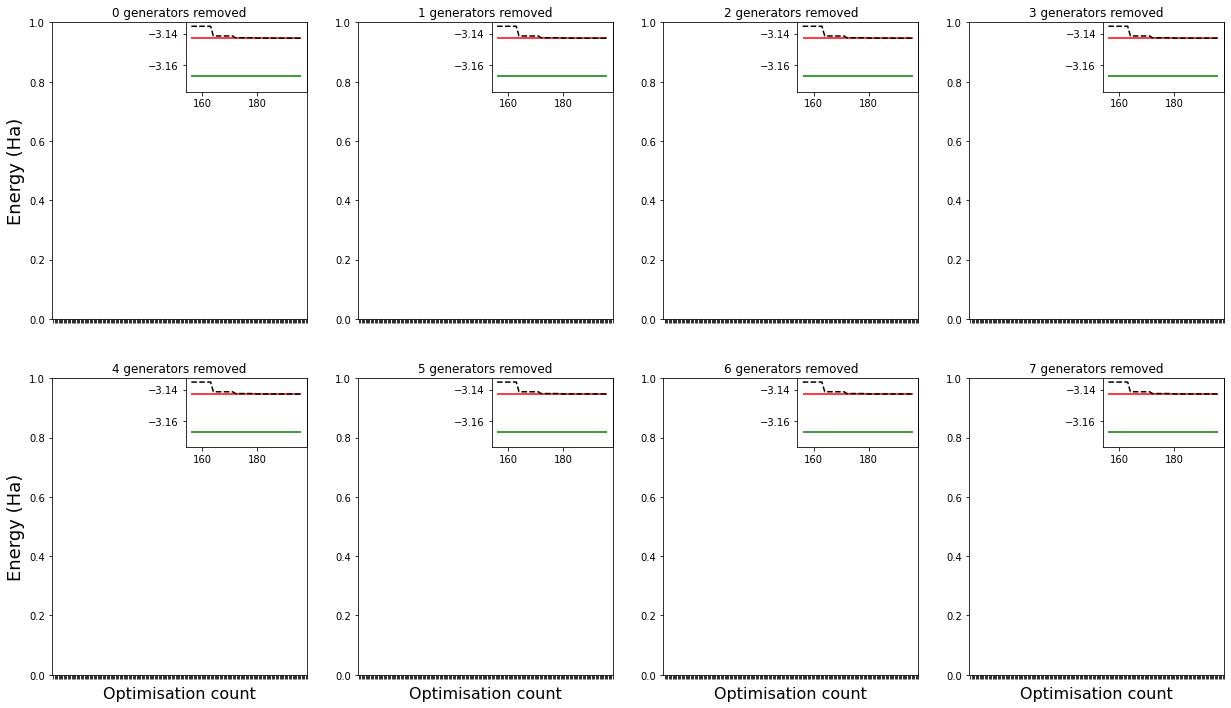

In [58]:
# create blank plot
fig, axs = plt.subplots(nrows = 2, ncols = 4, figsize = (21,12))
grid_pos = [(0,0),(0,1),(0,2),(0,3),(1,0),(1,1),(1,2),(1,3)]

#discard generators left to right whilst performing VQE
for index, grid in enumerate(grid_pos):
    # plot results in corresponding subfigure
    #axs[grid].plot(X, Y_noncon, color='orange',ls='--')
    ##axs[grid].scatter(X, Y_context, color='blue', marker = 'x')
    #axs[grid].plot(X, Y_context, color='blue')
    ##axs[grid].scatter(X, Y_combined, color='black', marker = 'x')
    #axs[grid].plot(X, Y_total, color='black')
    ##plt.plot(range(shots), Y_combined, color='purple')
    #axs[grid].hlines(gs_noncon_energy, 1, len(X), color='r')
    #axs[grid].hlines(true_gs, 1, len(X), color='g')
    
    axs[grid].set_xticks(X)
    axs[grid].set_title("%i generators removed" % abs(index))
    axs[grid].set_xticklabels([])
    
    #X_zoom = []
    #Y_zoom = []
    #for index, t in enumerate(Y_total):
    #    if t-0.01 < gs_noncon_energy:
    #        X_zoom.append(X[index])
    #        Y_zoom.append(t)

    # location for the zoomed portion
    #x=(grid[0]+1)%2
    #y=grid[1]
    ax_box = axs[grid].get_position()
    ax_origin = (ax_box.get_points())[1]
    sf_size = 0.08
    sub_axes = plt.axes([ax_origin[0]-sf_size, ax_origin[1]-sf_size, sf_size, sf_size]) 
    
    # plot the zoomed portion
    sub_axes.set_ylim((true_gs-0.01, gs_noncon_energy+0.01))
    sub_axes.plot(X_zoom, Y_zoom, color='black', ls='--')
    sub_axes.hlines(gs_noncon_energy, X_zoom[0], X_zoom[-1], color='r')
    sub_axes.hlines(true_gs, X_zoom[0], X_zoom[-1], color='g')
    
    
    if grid[0] == 1:
        axs[grid].set_xlabel('Optimisation count',fontsize=16)
    if grid[1] == 0:
        axs[grid].set_ylabel('Energy (Ha)',fontsize=18)
    #print('<H> w.r.t. simultaneous eigenstate:', expect)
    #print('Noncontextual approximation:', gs_noncon_energy)
    #print('Expectation values match?', abs(expect - gs_noncon_energy) < 10**-12) #sanity check - expectation values match?



In [57]:
axs[grid].get_position()

Bbox([[0.7315217391304348, 0.1250000000000001], [0.9000000000000001, 0.46818181818181825]])

In [38]:
help(type())

Help on class Bbox in module matplotlib.transforms:

class Bbox(BboxBase)
 |  Bbox(points, **kwargs)
 |  
 |  A mutable bounding box.
 |  
 |  Examples
 |  --------
 |  **Create from known bounds**
 |  
 |  The default constructor takes the boundary "points" ``[[xmin, ymin],
 |  [xmax, ymax]]``.
 |  
 |      >>> Bbox([[1, 1], [3, 7]])
 |      Bbox([[1.0, 1.0], [3.0, 7.0]])
 |  
 |  Alternatively, a Bbox can be created from the flattened points array, the
 |  so-called "extents" ``(xmin, ymin, xmax, ymax)``
 |  
 |      >>> Bbox.from_extents(1, 1, 3, 7)
 |      Bbox([[1.0, 1.0], [3.0, 7.0]])
 |  
 |  or from the "bounds" ``(xmin, ymin, width, height)``.
 |  
 |      >>> Bbox.from_bounds(1, 1, 2, 6)
 |      Bbox([[1.0, 1.0], [3.0, 7.0]])
 |  
 |  **Create from collections of points**
 |  
 |  The "empty" object for accumulating Bboxs is the null bbox, which is a
 |  stand-in for the empty set.
 |  
 |      >>> Bbox.null()
 |      Bbox([[inf, inf], [-inf, -inf]])
 |  
 |  Adding points to

/home/tim/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: MatplotlibDeprecationWarning: 
The figbox attribute was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use get_subplotspec().get_position(self.figure) instead.
  """Entry point for launching an IPython kernel.
